In [1]:
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bambi.plots import plot_cap

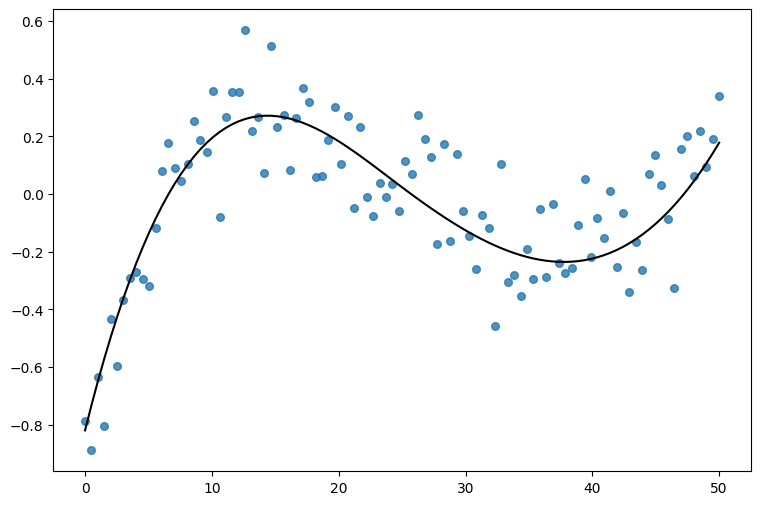

In [2]:
rng = np.random.default_rng(seed=121195)

N = 100
x = np.linspace(0, 50, N)
b = 0.1 * rng.normal(size=5)
sigma_t = 0.15

dm = design_matrices("0 + bs(x, df=5, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + sigma_t * rng.normal(size=N)

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [44]:
df = pd.DataFrame({"x": x, "y": y})
m = [10]
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1)
}
priors = {
    "hsgp(x, m=m, c=2, centered=True)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model = bmb.Model("y ~ 0 + hsgp(x, m=m, c=2, centered=True)", df, priors=priors)
model.set_alias({"hsgp(x, m=m, c=2, centered=True)": "hsgp"})

In [45]:
model

       Formula: y ~ 0 + hsgp(x, m=m, c=2, centered=True)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        HSGP effects
            hsgp(x, m=m, c=2, centered=True) ~ HSGP
        
        Auxiliary parameters
            y_sigma ~ HalfNormal(sigma: 10.0)

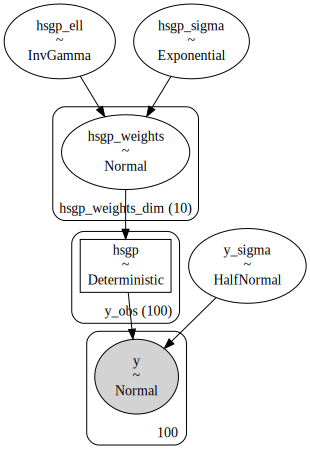

In [46]:
model.build()
model.graph()

In [47]:
idata = model.fit(inference_method="nuts_numpyro")

Compiling...
Compilation time =  0:00:03.715705
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:07.421813
Transforming variables...
Transformation time =  0:00:00.307203


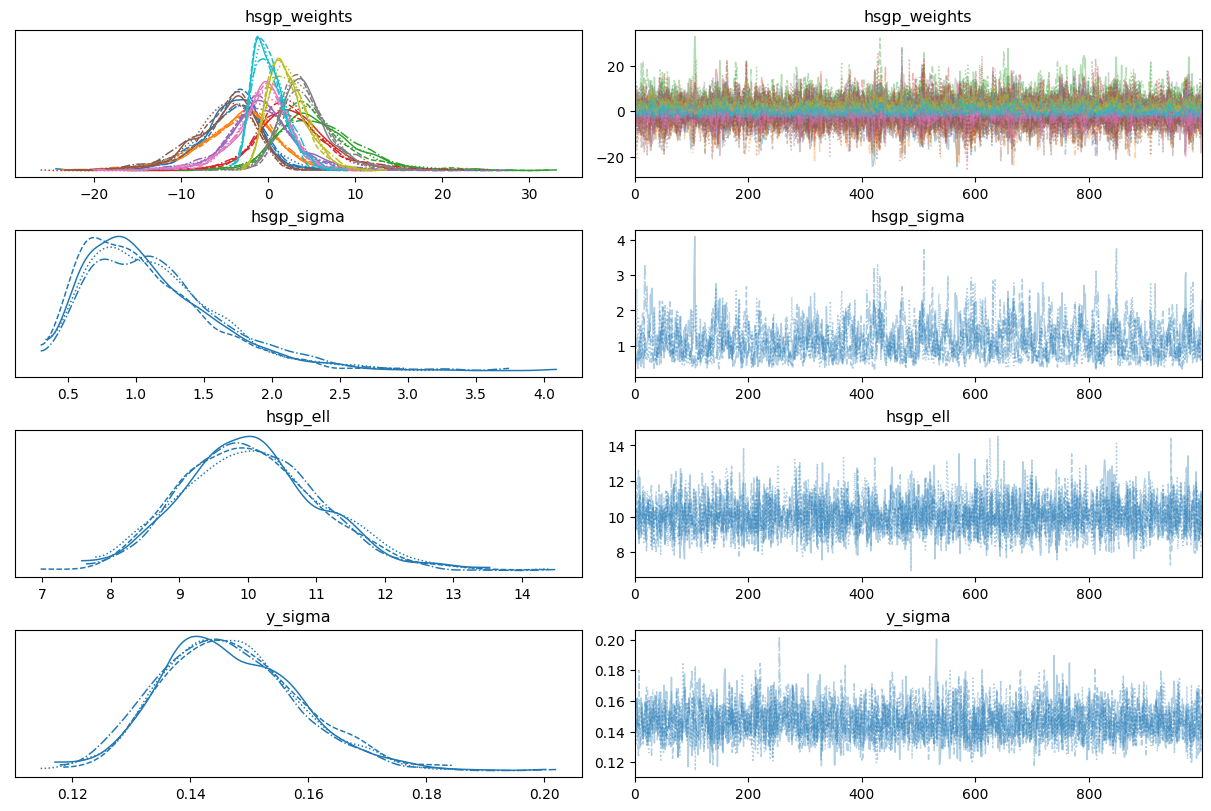

In [48]:
az.plot_trace(
    idata, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

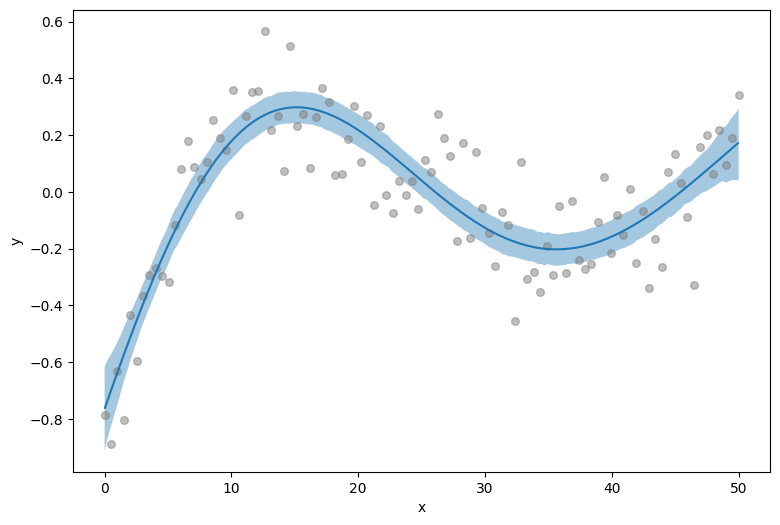

In [49]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_cap(model, idata, "x", ax=ax)
ax.scatter(df["x"], df["y"], s=30, color="0.5", alpha=0.5);

In [50]:
import pymc as pm

In [51]:
x_new = np.linspace(-10, 70, 500)
model.predict(idata, kind="pps", data=pd.DataFrame({"x": x_new}))
f_new = idata.posterior_predictive["y"].stack(sample=("chain", "draw")).T.to_numpy()

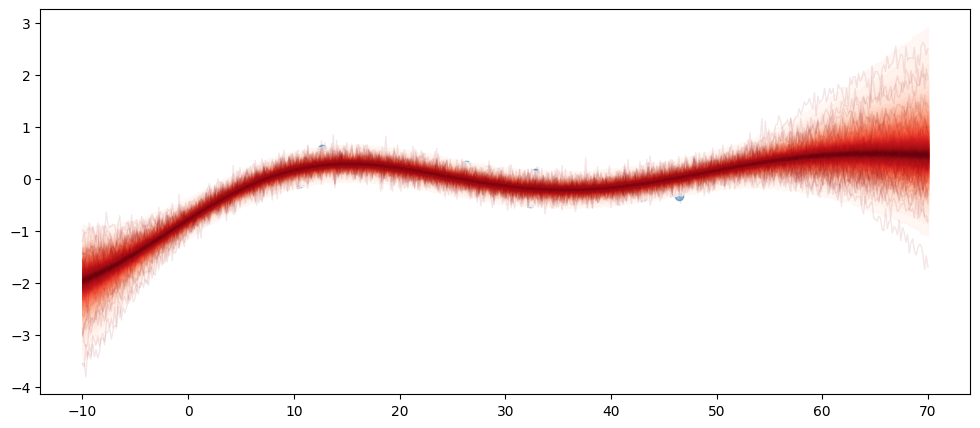

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(x, y, alpha=0.5);
pm.gp.util.plot_gp_dist(ax, f_new, x_new);

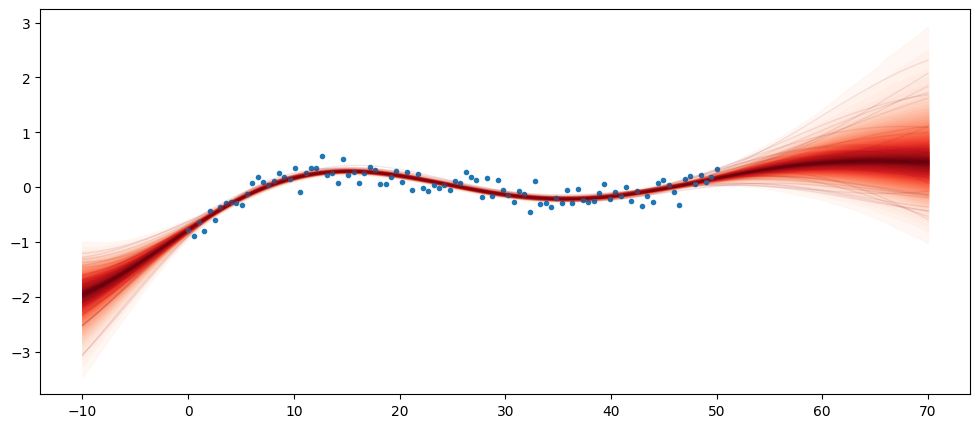

In [53]:
f_new = idata.posterior["hsgp"].stack(sample=("chain", "draw")).T.to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x, y, '.')
pm.gp.util.plot_gp_dist(ax, f_new, x_new);

---

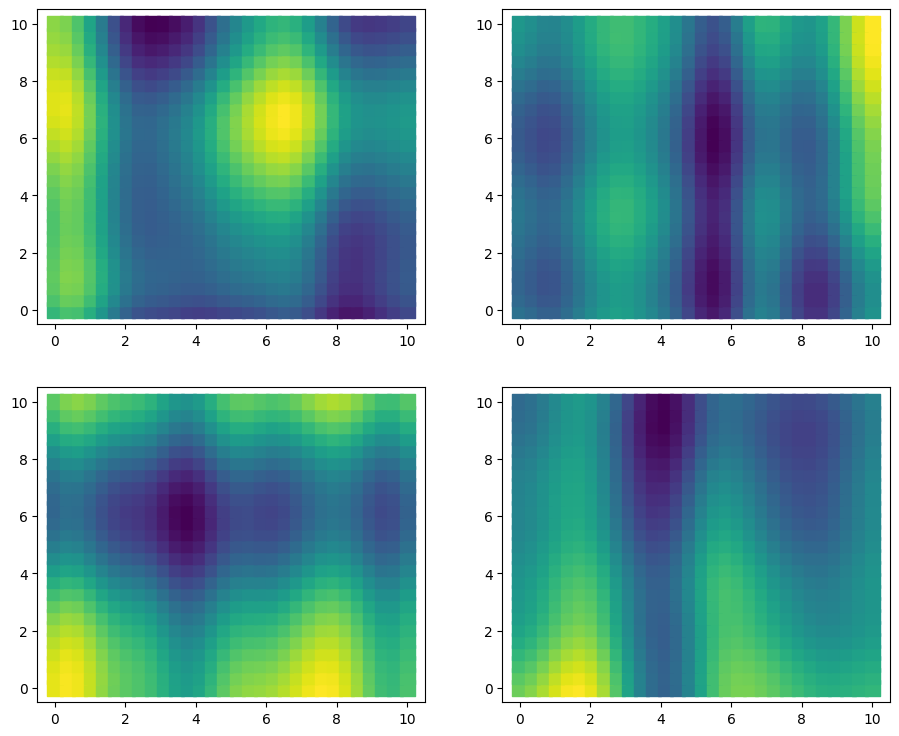

In [13]:
import pymc as pm
rng = np.random.default_rng(seed=1234)

# make X grid
x1 = np.linspace(0, 10, 30)
x2 = np.linspace(0, 10, 25)
xx, yy = np.meshgrid(x1, x2)
X = np.concatenate((yy.flatten()[:, None], xx.flatten()[:, None]), axis=1)

## row and range "factors"
ell_row = 2
cov_row = pm.gp.cov.ExpQuad(2, ls=ell_row, active_dims=[0])

ell_range = 1
cov_range = pm.gp.cov.ExpQuad(2, ls=ell_range, active_dims=[1])

## anisotropic
ell_anisotropic = [4, 2] # row and range lengthscales in product cov
cov_anisotropic = pm.gp.cov.ExpQuad(2, ls=ell_anisotropic)

cov = cov_row + cov_range + cov_anisotropic
K = cov(X).eval()

ff = rng.multivariate_normal(np.zeros(X.shape[0]), K, 4).T

fig, axs = plt.subplots(2, 2, figsize=(11, 9)); 
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.scatter(xx, yy, c=ff[:, i], s=120, marker="s")
    ax.grid(False) 

In [14]:
y = yy.flatten()
x = xx.flatten()
f = ff[:, 0]

df = pd.DataFrame({"x": x, "y": y, "f": f})
df.head()

,x,y,f
0,0.000000,0.0,2.783611
1,0.344828,0.0,3.131854
2,0.689655,0.0,3.055532
3,1.034483,0.0,2.536763
4,1.379310,0.0,1.749508


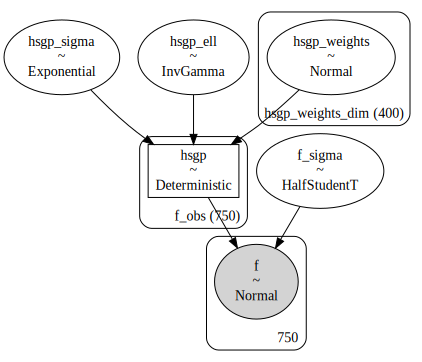

In [15]:
m = [20, 20]
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=1),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.5),
}
priors = {"hsgp(x, y, m=m, c = 1.2)": prior_hsgp}
model = bmb.Model("f ~ 0 + hsgp(x, y, m=m, c=1.2)", df, priors=priors)
model.set_alias({"hsgp(x, y, m=m, c=1.2)": "hsgp"})
model.build()
model.graph()

In [16]:
idata = model.fit(inference_method="nuts_numpyro")

Compiling...
Compilation time =  0:00:04.033628
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:05:18.180603
Transforming variables...
Transformation time =  0:00:00.973366


In [20]:
az.summary(idata, var_names=["hsgp_sigma", "hsgp_ell"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hsgp_sigma,2.000,0.247,1.578,2.481,0.010,0.007,614.0,1060.0,1.00
hsgp_ell,1.494,0.041,1.420,1.569,0.002,0.001,684.0,1576.0,1.01


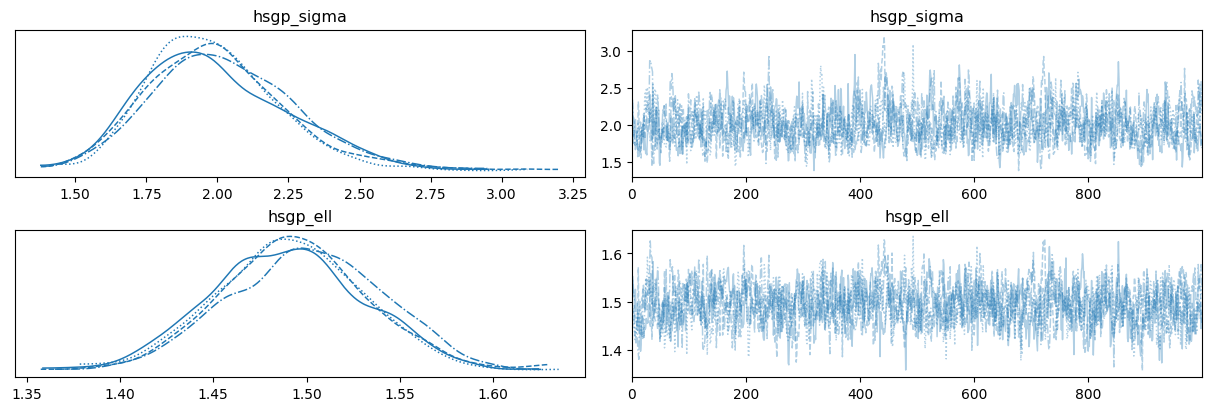

In [21]:
az.plot_trace(idata, var_names=["hsgp_sigma", "hsgp_ell"], backend_kwargs={"layout": "constrained"});

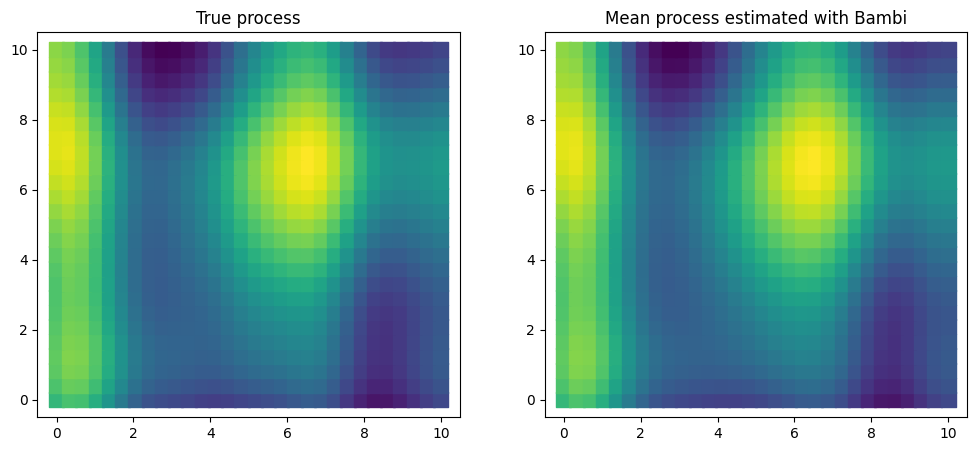

In [22]:
f_mean = idata.posterior["hsgp"].mean(("chain", "draw")).to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(xx, yy, c=ff[:, 0], s=120, marker="s")
axes[1].scatter(df["x"], df["y"], c=f_mean, s=120, marker="s")

axes[0].set_title("True process")
axes[1].set_title("Mean process estimated with Bambi")
axes[0].grid(False)
axes[1].grid(False)